# Visualizations

This notebook assists with loading visualization-related items.

Omix Data Shape: (4834,)


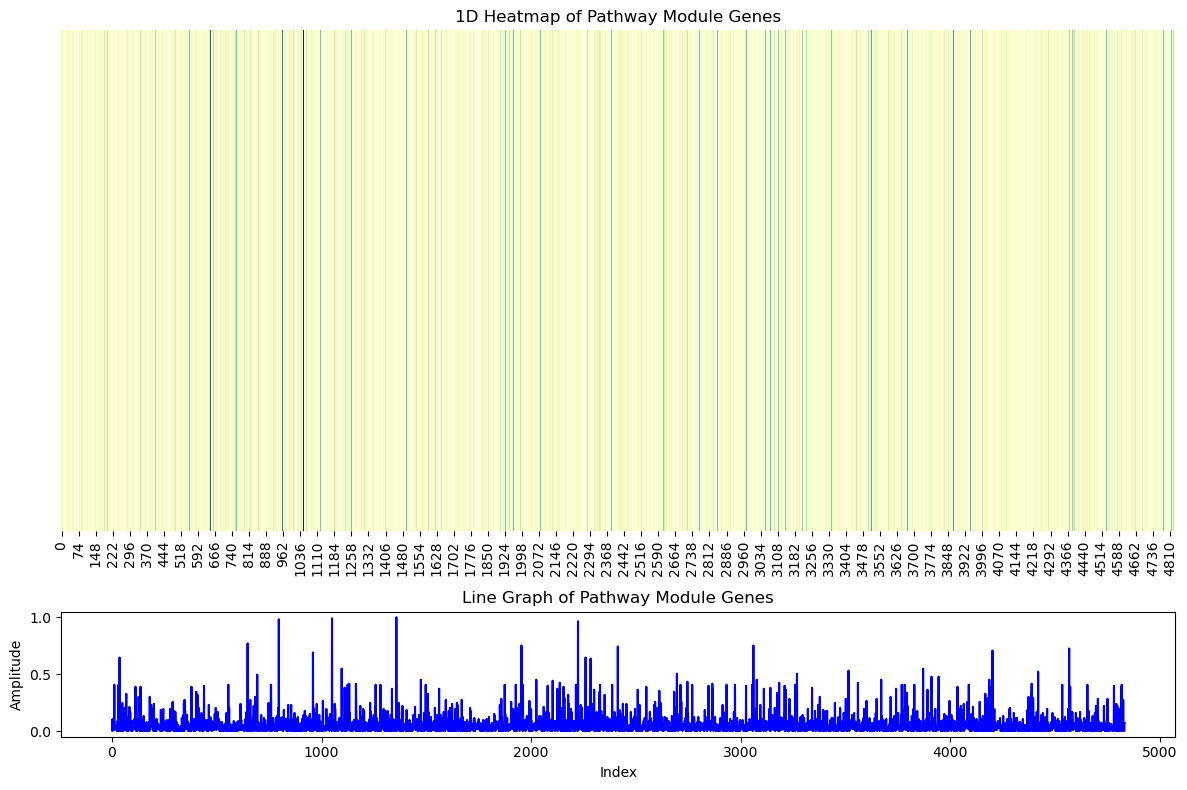

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import checkpoint


import numpy as np
import matplotlib.pyplot as plt
from model import SWEEM
from visualization import generateHeatmap, visualizePathwayModules
import seaborn as sns

In [148]:
data = pd.read_csv('./Data/OmicsData/data.csv')

# Separate to make sure that there's an even distribution of 1s and 0s in train and test
data_ones = data[data.iloc[:, -1] == 1]
data_zeros = data[data.iloc[:, -1] == 0]

# Split the data into train and validation sets.
train_data_ones, test_data_ones, train_labels_ones, test_labels_ones = train_test_split(
    data_ones.iloc[:, 1:-2], data_ones.iloc[:, -2:], test_size=0.2, random_state=42)
train_data_zeros, test_data_zeros, train_labels_zeros, test_labels_zeros = train_test_split(
    data_zeros.iloc[:, 1:-2], data_zeros.iloc[:, -2:], test_size=0.2, random_state=42)

# Concatenate in the end to make train and test
train_data = pd.concat((train_data_ones, train_data_zeros))
train_labels = pd.concat((train_labels_ones, train_labels_zeros))
test_data = pd.concat((test_data_ones, test_data_zeros)) 
test_labels = pd.concat((test_labels_ones, test_labels_zeros))

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(train_data.values, dtype=torch.float32), torch.tensor(train_labels.values, dtype=torch.float32))
test_dataset  = TensorDataset(torch.tensor(test_data.values, dtype=torch.float32), torch.tensor(test_labels.values, dtype=torch.float32))

# Create DataLoader objects
batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
settings = {
    "model": {
        "rna_dim": 5540,
        "scna_dim": 5507,
        "methy_dim": 4846,
        "use_rna": False,
        "use_scna": False,
        "use_methy": True,
        "hidden_dim": 32,
        "self_att": True,
        "cross_att": False,
        "device": device
    },
    "train": {
        "lr": 0.00001,
        "l2": 1e-3,
        "epochs":1001,
        "epoch_mod": 25
    }
}

### Model trained on methylation data. 
model, optimizer, epoch_train_losses, epoch_val_losses, settings = checkpoint.load("./sweem.model", SWEEM, optim.Adam)
model = SWEEM(**settings["model"])
model.load_state_dict(torch.load("./sweem_inference.model", map_location=device))

<All keys matched successfully>

In [ ]:
plt.close()
visualizePathwayModules(rna=True, scna=True, methy=True)

In [132]:
'''
Integrated gradients. This is a method for attributing importance to each feature
in the input. 

This has also been implemented in visualization.py.
'''
def integrated_gradients(model, event, kwarg_dict, baseline=None, num_steps=50):
    event = event.requires_grad_()
    kwarg_dict = {k: v.requires_grad_() for k, v in kwarg_dict.items()}
    input_data = kwarg_dict['methy']
    

    if baseline is None:
        baseline = torch.zeros_like(input_data)

    scaled_inputs = [baseline + (float(i) / num_steps) * (input_data - baseline) for i in range(num_steps + 1)]

    total_gradients = torch.zeros_like(input_data)

    criterion = torch.nn.BCELoss()

    for scaled_input in scaled_inputs:
        scaled_input = scaled_input.requires_grad_()
        # Compute the model outputs
        outputs = model(event=event, rna=kwarg_dict['rna'], scna=kwarg_dict['scna'], methy=scaled_input)
        # Compute the loss between the model outputs and the target
        loss = criterion(outputs, event)

        grads = torch.autograd.grad(loss, (event, kwarg_dict['rna'], kwarg_dict['scna'], scaled_input), allow_unused=True)[0]
        total_gradients += grads.detach()  # Detach to prevent memory leak

    # Calculate integrated gradients after the loop
    integrated_grad = (input_data - baseline) * total_gradients / num_steps
    return integrated_grad


In [155]:
# Integrated Gradients Interptability.
model.device = device

int_grad = np.zeros((4846))

for i, (batchX, batchY) in enumerate(test_dataloader):
    batchX = batchX.to(device)
    rna = batchX[:, :5540].to(device)
    scna = batchX[:, 5540:11047].to(device)
    methy = batchX[:, 11047:].to(device)
    time = batchY[:, 0].reshape(-1, 1).to(device)
    event = batchY[:, 1].reshape(-1, 1).to(device)
    outputs = model(event=event, rna=rna, scna=scna, methy=methy)

    kwarg_dict = {'rna':rna, 'scna':scna, 'methy':methy}
    baseline = torch.zeros_like(methy)
    integrated_grad = integrated_gradients(model, event, kwarg_dict, baseline=baseline)

    batch_integrated_gradient = integrated_grad.cpu().detach().numpy()
    int_grad += batch_integrated_gradient.reshape(-1)

print(int_grad/len(test_dataloader))

[ 0.31212877 -0.282792   -0.25535675 ... -0.21832457  0.15528399
  0.21370782]


In [165]:
### Single Sample Integrated Gradient Case.
singleton_int_grad = np.zeros((4846))

for i, (batchX, batchY) in enumerate(test_dataloader):
    if i == 0:
        batchX = batchX.to(device)
        rna = batchX[:, :5540].to(device)
        scna = batchX[:, 5540:11047].to(device)
        methy = batchX[:, 11047:].to(device)
        time = batchY[:, 0].reshape(-1, 1).to(device)
        event = batchY[:, 1].reshape(-1, 1).to(device)
        outputs = model(event=event, rna=rna, scna=scna, methy=methy)

        kwarg_dict = {'rna':rna, 'scna':scna, 'methy':methy}
        baseline = torch.zeros_like(methy)
        integrated_grad = integrated_gradients(model, event, kwarg_dict, baseline=baseline)

        batch_integrated_gradient = integrated_grad.cpu().detach().numpy()
        singleton_int_grad += batch_integrated_gradient.reshape(-1)
        break

In [189]:
## Scaling the Composite Grad and extracting the top 100 genes with their names.
avg_int_grad = int_grad / len(test_dataloader)
methy_labels = test_data.columns[11047:15893]

# Select the top 100 genes related. 
labels = [label.split('_')[0] for label in test_data.columns[11047:15893]]
gene_grad_pairs = [(labels[i], np.abs(avg_int_grad[i])) for i in range(len(methy_labels))]
gene_grad_pairs.sort(key=lambda x: x[1], reverse=True)
top_100_genes = gene_grad_pairs[:100]
outstr = ""
for gene in top_100_genes:
    outstr += "'" + gene[0] + "',"
print(outstr)

# The output string is used as an input to the Enrichr API to find the enriched pathways.
# (i.e.) https://maayanlab.cloud/Enrichr/

'ZNF492','SSTR1','FGFR3','CUL7','HPD','CNTNAP2','RELN','GATA6','SLC35D2','HTR1E','ACYP2','PCSK6','CADM1','OPRK1','RBKS','GABRG2','DUSP6','MRC2','CDH6','TLE4','SMPD3','TMOD1','P2RY1','HDC','CFLAR','CHRNA9','MAP3K13','SYN3','HTR3B','ACACB','GALNT14','SPRY1','THBS4','PNMT','CASP4','GRB7','TUBB1','VAV3','DLL3','DUSP10','CFTR','PDE10A','SFRP4','GABRB2','LAMA2','DKK2','MYOD1','DYNLL1','PXN','CXCL12','MRAS','CDKN2C','RPRM','SLIT2','CACNG2','RIPK1','ABCB4','ST6GALNAC5','SV2C','SLC6A20','GAS2','TACR1','ITGA8','MEF2C','HIST3H2A','FGF5','CRH','FMOD','CALCR','SLC25A21','CD9','ZNF274','PCSK1','RGS3','PKP2','TRADD','ST8SIA5','SOCS3','CDO1','HIST1H3G','SFRP1','OPRL1','GDNF','ACAN','ZNF544','RXFP3','ZYX','MCFD2','BMP4','ITGB3','CLCF1','FZD9','ITGAX','ATP8B1','CCL16','SULT2B1','KCNA4','PITPNA','ST8SIA2','LAP3',


/var/folders/tv/p_pr7fqj2z35lyv82g_qrrf00000gn/T/ipykernel_35648/2220841417.py:40: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical')


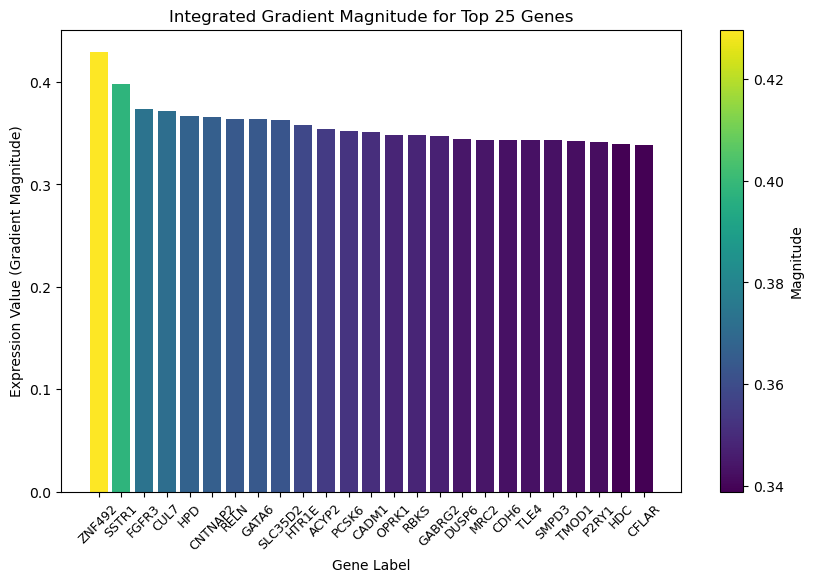

In [200]:
# labels, values = zip(*top_100_genes[:50])

# plt.figure(figsize=(10, 6))
# plt.bar(labels, values, color='blue')

# plt.xlabel('Genes')
# plt.ylabel('Expression Value (Gradient Magnitude)')
# plt.title('Top 50 Genes Expression')
# plt.xticks(rotation=45, fontsize=8)
# plt.show()

import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

top_50_genes = top_100_genes[:25]

labels, values = zip(*top_50_genes)

# Normalize values for colormap
norm = Normalize(vmin=min(values), vmax=max(values))

# Choose the "viridis" colormap
colormap = viridis

# Assign colors based on the normalized values
colors = [colormap(norm(value)) for value in values]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

plt.xlabel('Gene Label')
plt.ylabel('Expression Value (Gradient Magnitude)')
plt.title('Integrated Gradient Magnitude for Top 25 Genes')
plt.xticks(rotation=45, fontsize=9)

# Add a colorbar to indicate the magnitude
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  # You need to set an array to the mappable
cbar = plt.colorbar(sm, orientation='vertical')
cbar.set_label('Magnitude')

plt.show()

In [ ]:
# Attempted Model Attention Perturbation-based Interpretation.
## The captum attr library does not seem to support our input format of **kwargs,
## so we will have to rework the model to take in a single input. For now, we focus
## on other attention-based interpretability methods that we can use.

from captum.attr import LayerGradientXActivation
model.device = device

layer_grad_x_activation = LayerGradientXActivation(model, model.methyl_att)

with torch.no_grad():
    for i, (batchX, batchY) in enumerate(test_dataloader):
        batchX = batchX.to(device)
        rna = batchX[:, :5540].to(device)
        scna = batchX[:, 5540:11047].to(device)
        methy = batchX[:, 11047:].to(device)
        time = batchY[:, 0].reshape(-1, 1).to(device)
        event = batchY[:, 1].reshape(-1, 1).to(device)
        outputs = model(event=event, rna=rna, scna=scna, methy=methy)

        attributions, delta = layer_grad_x_activation.attribute({'methy':methy})
        # attributions = attributions.squeeze().cpu().detach().numpy()

        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # axs[0].imshow(methy[0].cpu().detach().numpy(), cmap='viridis', aspect='auto')
        # axs[0].set_title('Original Methy Input')

        # axs[1].imshow((methy + delta)[0].cpu().detach().numpy(), cmap='viridis', aspect='auto')
        # axs[1].set_title('Perturbed Methy Input')

        # axs[2].imshow(attributions[0], cmap='seismic', aspect='auto')
        # axs[2].set_title('Attributions')

        # plt.show()
        break
